In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
df = pd.read_csv("../../datasets/IndiaDataset/india_inflation_dataset.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print("📊 Dataset Shape:", df.shape)
print(df.head())


📊 Dataset Shape: (200, 13)
        Date       CPI  GDP_Growth  Unemployment_Rate  Crude_Oil_Prices  \
0 2007-01-31  5.745071    6.715575           5.086687         81.354829   
1 2007-02-28  4.792604    7.121569           6.280750         56.167520   
2 2007-03-31  5.971533    8.166102           7.006292         83.044089   
3 2007-04-30  7.284545    8.107604           7.056377         90.334568   
4 2007-05-31  4.648770    3.244661           6.459921         76.201524   

   Gold_Prices  Real_Estate_Index   Stock_Index  Money_Supply_M1  \
0  1687.656761         140.990332  40626.122513         6.859267   
1  1396.791054         133.869505  37852.972294        11.609958   
2  1519.224155         120.894456  40611.487515        13.557112   
3  1407.544942         110.295948  42716.490145        12.156860   
4  1413.100755         130.473350  40244.300352        12.988143   

   Money_Supply_M2  Industrial_Production  Retail_Sales  Exchange_Rate  
0        11.451311               8.80238

In [28]:
# Frature engineering

df_fe = df.copy()

# Add lags for major indicators
for col in ["CPI", "GDP_Growth", "Unemployment_Rate",
            "Crude_Oil_Prices", "Gold_Prices",
            "Real_Estate_Index", "Stock_Index"]:
    for lag in [1, 3, 6, 12]:
        df_fe[f"{col}_lag{lag}"] = df_fe[col].shift(lag)

# Moving averages for smoother trends
for col in ["CPI", "Gold_Prices", "Stock_Index"]:
    df_fe[f"{col}_ma3"] = df_fe[col].rolling(window=3).mean()
    df_fe[f"{col}_ma6"] = df_fe[col].rolling(window=6).mean()

# Volatility for market-driven features
for col in ["Stock_Index", "Gold_Prices"]:
    df_fe[f"{col}_volatility"] = df_fe[col].rolling(window=3).std()

# Seasonality (month sin/cos)
df_fe["month"] = df_fe["Date"].dt.month

df_fe["month_sin"] = np.sin(2 * np.pi * df_fe["month"] / 12)
df_fe["month_cos"] = np.cos(2 * np.pi * df_fe["month"] / 12)
df_fe.drop(columns=["month"], inplace=True)

# Drop NA from lag/rolling
df_fe = df_fe.dropna().reset_index(drop=True)

print("✅ After Feature Engineering:", df_fe.shape)


✅ After Feature Engineering: (188, 51)


In [29]:
target_col = "CPI"   
features = df_fe.drop(columns=["Date", target_col])
target = df_fe[target_col]

# Scale features
X_scaler = MinMaxScaler()
features_scaled = X_scaler.fit_transform(features)

# Scale target
y_scaler = MinMaxScaler()
target_scaled = y_scaler.fit_transform(target.values.reshape(-1,1))

In [30]:
#Creating Sequence

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24
X_seq, y_seq = create_sequences(features_scaled, target_scaled, TIME_STEPS)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")

✅ Train: (131, 24, 49), Test: (33, 24, 49)


In [86]:
# GRU-RNN model

model = Sequential([
    GRU(128, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation="tanh"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mae", metrics=["mse"])
model.summary()

c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_15 (GRU)                    │ (None, 12, 128)        │        60,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_16 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,761 (397.50 KB)

 Trainable params: 101,761 (397.50 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# Training 

early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
history = model.fit(
        X_train, y_train,
           validation_data=(X_test, y_test),
           epochs=200,
           batch_size=16,
           callbacks=[early_stop],
           verbose=1
      )

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.8037 - mse: 1.1886 - val_loss: 0.5525 - val_mse: 0.4520
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7380 - mse: 1.1067 - val_loss: 0.5399 - val_mse: 0.4314
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7237 - mse: 1.0800 - val_loss: 0.5285 - val_mse: 0.4144
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7017 - mse: 1.0604 - val_loss: 0.5352 - val_mse: 0.4095
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6844 - mse: 1.0398 - val_loss: 0.5378 - val_mse: 0.4230
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6561 - mse: 0.9648 - val_loss: 0.5212 - val_mse: 0.4165
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6114 - mse: 0.8683 - val_loss: 0.5072 - val_mse: 0.3953
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6194 - mse: 0.8537 - val_loss: 0.4975 - val_mse: 0.4082
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5926 - mse: 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A187111BD0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step


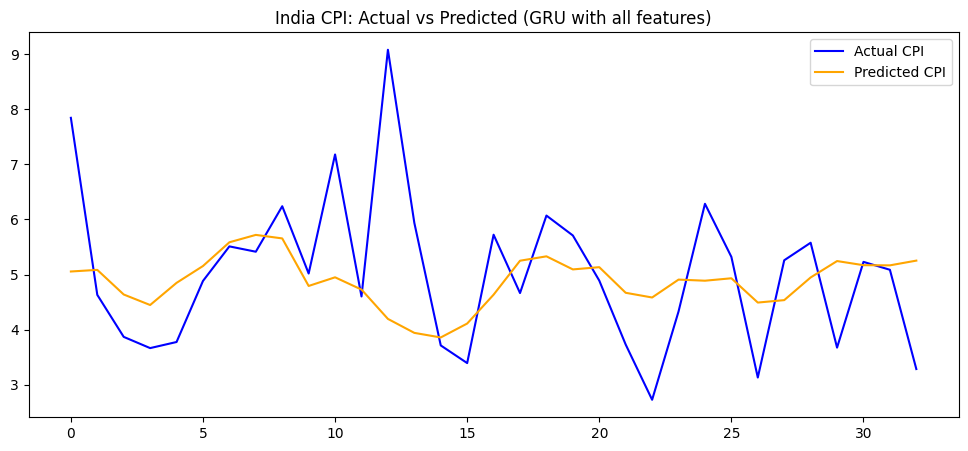

In [33]:
# Predictions 

y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_actual, label="Actual CPI", color="blue")
plt.plot(y_pred, label="Predicted CPI", color="orange")
plt.title("India CPI: Actual vs Predicted (GRU with all features)")
plt.legend()
plt.show()

In [34]:
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
r2 = r2_score(y_actual, y_pred)

print(f"📌 Target: {target_col}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

📌 Target: CPI
MAE: 0.98
RMSE: 1.38
MAPE: 19.91%
R² Score: -0.0213


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# y_actual and y_pred should be in original scale (inverse transformed if scaled)
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
r2 = r2_score(y_actual, y_pred)

# Approximate "accuracy" as 100 - MAPE
accuracy = 100 - mape

print(f"📌 Target: {target_col}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"Approximate Accuracy: {accuracy:.2f}%")


📌 Target: CPI
MAE: 0.98
RMSE: 1.38
MAPE: 19.91%
R² Score: -0.0213
Approximate Accuracy: 80.09%


In [36]:
# Save trained model
model.save("inflation_gru_model.h5")
print("✅ Model saved as inflation_gru_model.h5")


✅ Model saved as inflation_gru_model.h5


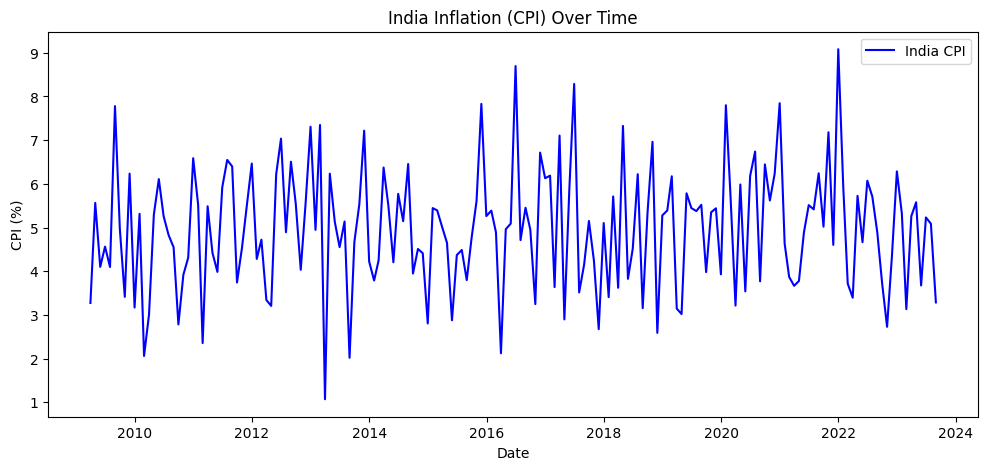

In [89]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["CPI"], label="India CPI", color="blue")
plt.xlabel("Date")
plt.ylabel("CPI (%)")
plt.title("India Inflation (CPI) Over Time")
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


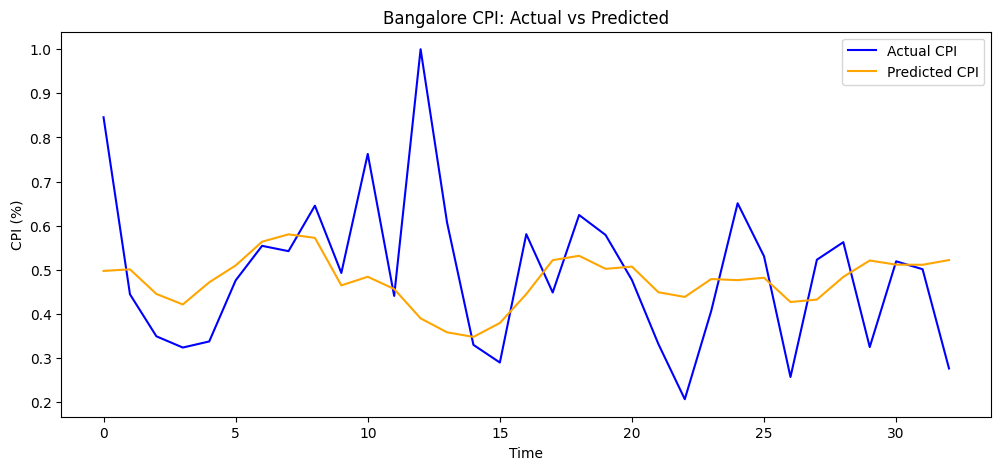

In [39]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test, label="Actual CPI", color="blue")
plt.plot(y_pred, label="Predicted CPI", color="orange")
plt.xlabel("Time")
plt.ylabel("CPI (%)")
plt.title("Bangalore CPI: Actual vs Predicted")
plt.legend()
plt.show()


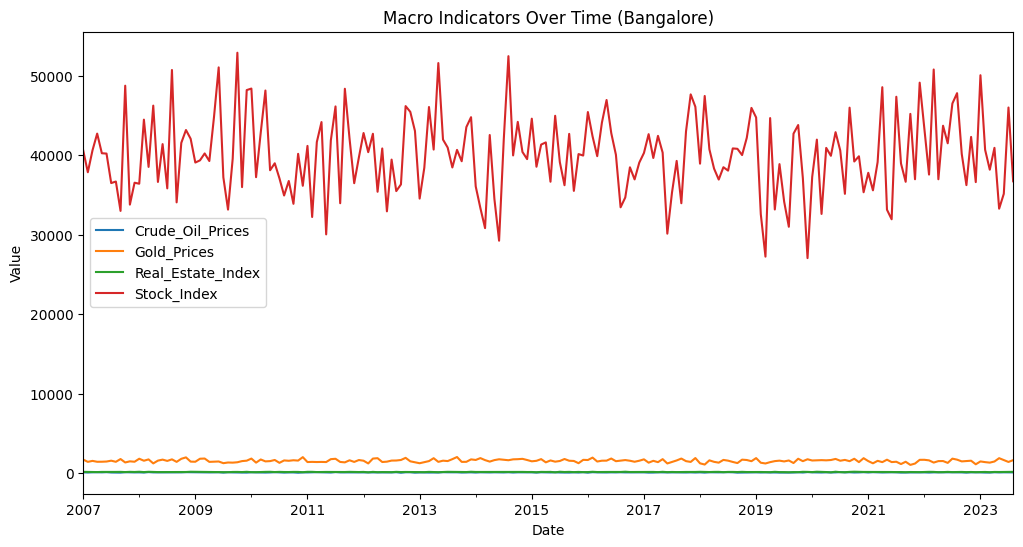

In [40]:
feature_cols = ["Crude_Oil_Prices", "Gold_Prices", "Real_Estate_Index", "Stock_Index"]

df.set_index("Date")[feature_cols].plot(figsize=(12,6))
plt.title("Macro Indicators Over Time (Bangalore)")
plt.ylabel("Value")
plt.show()


In [41]:
df['Gold_diff'] = df['Gold_Prices'].pct_change()
df['RealEstate_diff'] = df['Real_Estate_Index'].pct_change()

In [42]:
df = df.dropna().reset_index(drop=True)

In [43]:
for col in ['Gold_diff', 'RealEstate_diff']:
    for lag in [1, 3, 6, 12]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)
    # Optional rolling mean/volatility
    df[f'{col}_ma3'] = df[col].rolling(window=3).mean()
    df[f'{col}_vol'] = df[col].rolling(window=3).std()

df = df.dropna().reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = [c for c in df.columns if c not in ['Date']]  # include CPI, Gold_diff, RealEstate_diff + lags
X_scaler = StandardScaler()
features_scaled = X_scaler.fit_transform(df[feature_cols])

# If you want to predict multiple outputs:
y_scaler = StandardScaler()
target_cols = ['Gold_diff', 'RealEstate_diff']
target_scaled = y_scaler.fit_transform(df[target_cols])

In [45]:
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 12
X_seq, y_seq = create_sequences(features_scaled, target_scaled, TIME_STEPS)

train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

✅ Train shape: (140, 12, 26), Test shape: (35, 12, 26)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_gold_real = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(2)  # two outputs: Gold_diff, RealEstate_diff
])

model_gold_real.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_gold_real.summary()


c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                     │ (None, 12, 128)        │        59,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,442 (396.26 KB)

 Trainable params: 101,442 (396.26 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model_gold_real.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 1.0647 - mae: 0.7917 - val_loss: 0.8796 - val_mae: 0.7759
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.9519 - mae: 0.7436 - val_loss: 0.8517 - val_mae: 0.7551
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8560 - mae: 0.7020 - val_loss: 0.8313 - val_mae: 0.7318
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7752 - mae: 0.6790 - val_loss: 0.8261 - val_mae: 0.7164
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6653 - mae: 0.6324 - val_loss: 0.8229 - val_mae: 0.6957
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5638 - mae: 0.5723 - val_loss: 0.8206 - val_mae: 0.6961
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4551 - mae: 0.5159 - val_loss: 0.8709 - val_mae: 0.7151
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3842 - mae: 0.4869 - val_loss: 0.9123 - val_mae: 0.7384
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3255 - mae: 

In [48]:
y_pred_scaled = model_gold_real.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step


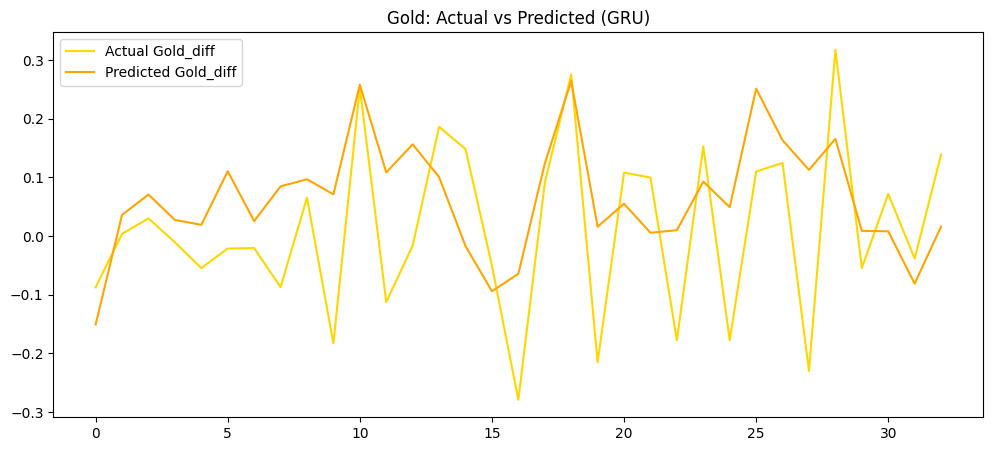

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_actual[:,0], label="Actual Gold_diff", color="gold")
plt.plot(y_pred[:,0], label="Predicted Gold_diff", color="orange")
# plt.plot(y_actual[:,1], label="Actual RealEstate_diff", color="green")
# plt.plot(y_pred[:,1], label="Predicted RealEstate_diff", color="red")
plt.title("Gold: Actual vs Predicted (GRU)")
plt.legend()
plt.show()

In [68]:
model.save("inflation_gru_model_FOr_Gold_prizes.h5")
print("✅ Model saved as inflation_gru_model_FOr_Gold_prizes.h5")

✅ Model saved as inflation_gru_model_FOr_Gold_prizes.h5


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


for i, col in enumerate(['Gold_diff']):
    actual = y_actual[:, i]
    pred = y_pred[:, i]

    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    r2 = r2_score(actual, pred)
    accuracy = 100 - mape  

    print(f"\n📌 Target: {col}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    print(f"Approximate Accuracy: {accuracy:.2f}%")



📌 Target: Gold_diff
MAE: 0.1107
RMSE: 0.1385
MAPE: 173.32%
R² Score: 0.1166
Approximate Accuracy: -73.32%


In [51]:
# Use percentage change (more variance for the model to learn)
df['RealEstate_diff'] = df['Real_Estate_Index'].pct_change()  # or .diff()
df = df.dropna().reset_index(drop=True)

In [52]:
# Lags
for lag in [1, 3, 6, 12]:
    df[f'RealEstate_diff_lag{lag}'] = df['RealEstate_diff'].shift(lag)

# Rolling mean & volatility
df['RealEstate_ma3'] = df['RealEstate_diff'].rolling(window=3).mean()
df['RealEstate_vol'] = df['RealEstate_diff'].rolling(window=3).std()

df = df.dropna().reset_index(drop=True)

In [59]:
# After feature engineering & creating RealEstate_diff
df = df.dropna().reset_index(drop=True)

# Select features and target
features = df.drop(columns=['Date', 'RealEstate_diff'])  # example
target = df[['RealEstate_diff']]

# Scale
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
features_scaled = X_scaler.fit_transform(features)

y_scaler = StandardScaler()
target_scaled = y_scaler.fit_transform(target)

In [60]:
# Only Real Estate differences as target
target_col = 'RealEstate_diff'
y_scaler = StandardScaler()
target_scaled = y_scaler.fit_transform(df[[target_col]])  # NOTE double brackets → 2D

# Sequence preparation
TIME_STEPS = 12
X_seq, y_seq = create_sequences(features_scaled, target_scaled, TIME_STEPS)

# Split train/test
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print("✅ X_train:", X_train.shape)
print("✅ y_train:", y_train.shape)

✅ X_train: (129, 12, 27)
✅ y_train: (129, 1)


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_realestate = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # single output
])

model_realestate.compile(optimizer='adam', loss='mse', metrics=['mae'])


c:\Web development\GRU-RNN_InflationModel\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model_realestate.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 1.2127 - mae: 0.8354 - val_loss: 0.4907 - val_mae: 0.5714
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0834 - mae: 0.7591 - val_loss: 0.4727 - val_mae: 0.5474
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0127 - mae: 0.7228 - val_loss: 0.4426 - val_mae: 0.5183
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8923 - mae: 0.7013 - val_loss: 0.5609 - val_mae: 0.5472
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8252 - mae: 0.6886 - val_loss: 0.5765 - val_mae: 0.5586
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7727 - mae: 0.6651 - val_loss: 0.5508 - val_mae: 0.5564
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6245 - mae: 0.5832 - val_loss: 0.5500 - val_mae: 0.5750
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6074 - mae: 0.5849 - val_loss: 0.4419 - val_mae: 0.5278
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5673 - mae: 

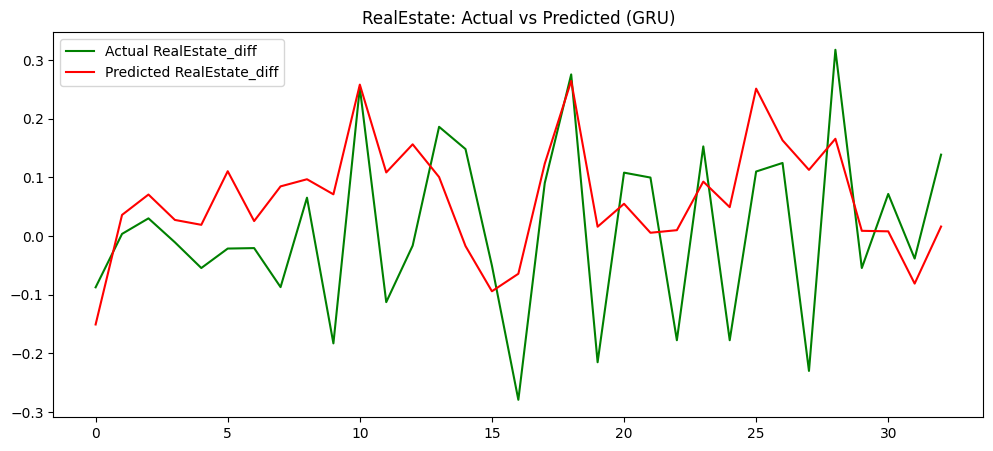

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
# plt.plot(y_actual[:,0], label="Actual Gold_diff", color="gold")
# plt.plot(y_pred[:,0], label="Predicted Gold_diff", color="orange")
plt.plot(y_actual[:,0], label="Actual RealEstate_diff", color="green")
plt.plot(y_pred[:,0], label="Predicted RealEstate_diff", color="red")
plt.title("RealEstate: Actual vs Predicted (GRU)")
plt.legend()
plt.show()

In [80]:
y_pred_scaled = model_realestate.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
r2 = r2_score(y_actual, y_pred)
accuracy = 100 - mape

print(f"📌 Real Estate Prediction Metrics")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"Approximate Accuracy: {accuracy:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
📌 Real Estate Prediction Metrics
MAE: 0.1107
RMSE: 0.1385
MAPE: 173.32%
R² Score: 0.1166
Approximate Accuracy: -73.32%


In [72]:
model.save("inflation_gru_model_For_RealEstate_prizes.h5")
print("✅ Model saved as inflation_gru_model_FOr_Gold_prizes.h5")

✅ Model saved as inflation_gru_model_FOr_Gold_prizes.h5
